In [1]:
!pip install -q osmnx

  You can safely remove it manually.
  You can safely remove it manually.


In [2]:
import graph_search_algorithm_compilation
import matplotlib.pyplot as plt
import networkx as nx
import nx_cugraph as nxcg
import random
import time
import osmnx as ox

# from joblib import Parallel, delayed
from tqdm import tqdm
from dask.distributed import Client
from dask import delayed, compute

In [3]:
if 'client' in globals():
    client.close()
client = Client(memory_limit='auto')

/opt/conda/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42819 instead
  warnings.warn(


In [4]:
# Generate a random weighted graph for the simulation
def generate_random_graph(num_nodes, prob=0.1, max_weight=10):
    G = nx.gnp_random_graph(num_nodes, prob, directed=True)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.randint(1, max_weight)
    return G

In [5]:
# Apply flood conditions to the graph
def apply_flood_conditions(G, flood_probability):
    flooded_edges = []
    for u, v in list(G.edges()):
        if random.random() < flood_probability:
            flooded_edges.append((u, v))
            G.remove_edge(u, v)  # Remove the flooded edges from the graph
    return G

In [6]:
algorithms = {
    "Dijkstra": graph_search_algorithm_compilation.dijkstra_search,
    "Floyd-Warshall": graph_search_algorithm_compilation.floyd_warshall_search,
    "Bellman-Ford": graph_search_algorithm_compilation.bellman_ford_search,
    "Bidirectional": graph_search_algorithm_compilation.bidirectional_search,
    "Dynamic": graph_search_algorithm_compilation.dynamic_shortest_path,
    # "D* Lite": graph_search_algorithm_compilation.d_star_lite,
    "A* Search": graph_search_algorithm_compilation.a_star_search,
    # "MCTS": graph_search_algorithm_compilation.monte_carlo_tree_search,
    "Yen's K-Shortest Paths": graph_search_algorithm_compilation.yen_k_shortest_paths,
    # "ACO": graph_search_algorithm_compilation.ant_colony_optimization,
}

In [7]:
def create_subgraph(G):
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    SG = G.__class__()
    SG.add_nodes_from((n, G.nodes[n]) for n in largest_wcc)
    if SG.is_multigraph():
        SG.add_edges_from(
            (n, nbr, key, d)
            for n, nbrs in G.adj.items()
            if n in largest_wcc
            for nbr, keydict in nbrs.items()
            if nbr in largest_wcc
            for key, d in keydict.items()
        )
    else:
        SG.add_edges_from(
            (n, nbr, d)
            for n, nbrs in G.adj.items()
            if n in largest_wcc
            for nbr, d in nbrs.items()
            if nbr in largest_wcc
        )
    SG.graph.update(G.graph)
    return SG

In [8]:
def create_coarse_graph(G, communities):  # TODO: Increase Efficiency
    supernode_graph = nx.Graph()

    # Add nodes representing communities
    for i, community in enumerate(communities):
        supernode_graph.add_node(i)

    # Add edges between communities based on connections in the original graph
    for i, community1 in enumerate(communities):
        for j, community2 in enumerate(communities):
            if i != j:
                # Find edges between these two communities
                inter_community_edges = [(u, v) for u in community1 for v in community2 if G.has_edge(u, v)]
                
                if inter_community_edges:
                    # Set the weight of the superedge (use minimum weight of inter-community edges)
                    min_weight = min(G[u][v]['weight'] for u, v in inter_community_edges)
                    supernode_graph.add_edge(i, j, weight=min_weight)

    return supernode_graph


def find_community(node, communities):  # TODO: Increase Efficiency
    # Find which community the node belongs to
    for i, community in enumerate(communities):
        if node in community:
            return i
    return None


def hierarchical_shortest_path(G, supernode_graph, communities, source, target, algorithm):
    # Step 1: Find the community for the source and target nodes
    source_community = find_community(source, communities)
    target_community = find_community(target, communities)
    
    # Step 2: Find shortest path between these communities in the supernode graph
    superpath = nx.shortest_path(supernode_graph, source=source_community, target=target_community)

    # Step 3: Refine the path within the communities
    full_path = [source]  # Start with the source node
    current_node = source

    for i in range(len(superpath) - 1):
        community1 = superpath[i]
        community2 = superpath[i + 1]

        # Find the nodes in the original graph connecting these two communities
        boundary_nodes = [(u, v) for u in communities[community1] for v in communities[community2] if G.has_edge(u, v)]
        if not boundary_nodes:
            raise Exception("No path between these communities in the original graph")

        # Select one of the boundary nodes to connect the communities (you can use min weight or some heuristic)
        boundary_node = min(boundary_nodes, key=lambda x: G[x[0]][x[1]]['weight'])
        
        # Find the shortest path from current_node to boundary_node[0] in the original graph
        path_within_community = algorithm(G, source=current_node, target=boundary_node[0])
        full_path.extend(path_within_community[1:])  # Extend the path

        # Set the next node to the node at the boundary
        current_node = boundary_node[1]

    # Find shortest path from the last boundary node to the target node
    final_path = algorithm(G, source=current_node, target=target)
    full_path.extend(final_path[1:])

    return full_path

In [9]:
# Parallel execution using Dask
@delayed
def evaluate_algorithm(G, supernode_graph, communities, source, target, algorithm):
    start_time = time.time()
    try:
        # Call the algorithm with (G, source, target, weight)
        path = hierarchical_shortest_path(G, supernode_graph, communities, source, target, algorithm)
        duration = time.time() - start_time
        if path is None:
            return float('inf'), []  # Infinite cost for no path found
        return duration, path  # Return computation time and the path
    except Exception as e:
        return float('inf'), []  # Infinite cost for errors


# Run algorithms in parallel using Dask
def run_in_parallel(algorithms, graph, source, target):
    communities, supernode_graph = detect_communities_and_supernode_graph(graph)

    delayed_results = [
        evaluate_algorithm(graph, supernode_graph, communities, source, target, algo_func) 
        for algo_func in algorithms.values()
    ]

    results = compute(*delayed_results)
    return results


# Step 1: Detect Louvain communities and create the supernode graph
def detect_communities_and_supernode_graph(G):
    communities = nx.community.louvain_communities(G)
    supernode_graph = create_coarse_graph(G, communities)
    return communities, supernode_graph
    

# Monte Carlo Simulation: Run all algorithms in parallel on the same graph
def monte_carlo_simulation(graph, num_iterations):
    algorithm_performance = {name: [] for name in algorithms.keys()}  # Track performance for each algorithm

    source = random.choice(list(graph.nodes()))
    target = random.choice(list(graph.nodes()))

    # Ensure source and target are not the same
    while source == target:
        target = random.choice(list(graph.nodes()))

    # Step 4: Evaluate all algorithms in parallel over the same graph, flooded conditions, and source/target
    for _ in tqdm(range(num_iterations)):
        results = run_in_parallel(algorithms, graph.copy(), source, target)

        # Store results in performance dictionary
        for algo_name, result in zip(algorithms.keys(), results):
            algorithm_performance[algo_name].append(result)

    return algorithm_performance

In [10]:
# Choose the best algorithm based on the performance and return the best result
def choose_best_algorithm(algorithm_performance):
    # Calculate average performance for each algorithm
    avg_performance = {
        algo: sum(duration for duration, _ in times) / len(times)
        for algo, times in algorithm_performance.items()
    }

    # Select the algorithm with the lowest average time
    best_algorithm = min(avg_performance, key=avg_performance.get)

    # Output the performance of all algorithms
    print(f"Best algorithm: {best_algorithm}")
    for algo, avg_time in avg_performance.items():
        print(f"{algo}: {avg_time:.4f} seconds (average)")

    # Return the best algorithm and its last run output (path)
    best_run = algorithm_performance[best_algorithm][-1]  # Get the last run result
    return best_algorithm, best_run[1]  # Return the algorithm name and its path

In [13]:
# Monte Carlo Simulation Parameters
iterations = 1000  # Number of Monte Carlo iterations
graph_size = 50    # Number of nodes in the graph
flooded_road_probability = 0.1  # Probability that a road gets flooded

G = generate_random_graph(graph_size)

# apply flood conditions once
graph = apply_flood_conditions(G, flooded_road_probability)
# graph = nxcg.from_networkx(graph)

In [12]:
# Run the simulation
algorithm_performance = monte_carlo_simulation(graph, iterations)

100%|██████████| 1000/1000 [01:06<00:00, 15.04it/s]


Best algorithm: Bidirectional
Dijkstra: 0.0004 seconds (average)
Floyd-Warshall: inf seconds (average)
Bellman-Ford: 0.0077 seconds (average)
Bidirectional: 0.0001 seconds (average)
Dynamic: 0.0003 seconds (average)
A* Search: 0.0004 seconds (average)
Yen's K-Shortest Paths: inf seconds (average)
Best path found by Bidirectional: [15, 41]


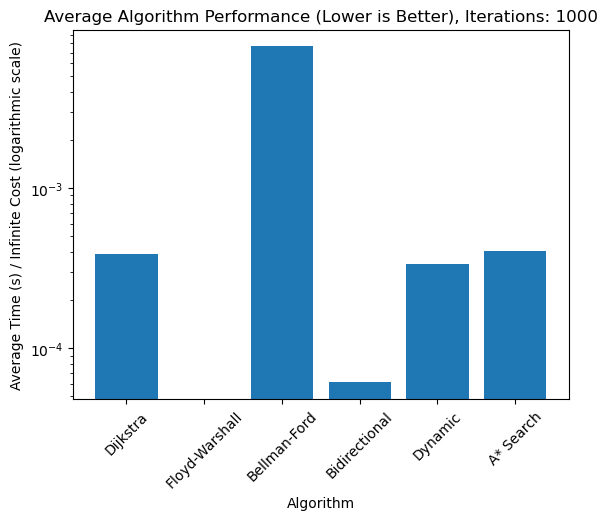

In [14]:
# Choose the best algorithm based on performance
best_algorithm, best_path = choose_best_algorithm(algorithm_performance)

# Display the best algorithm's path
print(f"Best path found by {best_algorithm}: {best_path}")

# Plot the average performance
average_performance = {
    algo: sum(duration for duration, _ in times) / len(times)
    for algo, times in algorithm_performance.items()
}
plt.bar(average_performance.keys(), average_performance.values())
plt.title(f"Average Algorithm Performance (Lower is Better), Iterations: {iterations}")
plt.yscale('log')
plt.xlabel("Algorithm")
plt.ylabel("Average Time (s) / Infinite Cost (logarithmic scale)")
plt.xticks(rotation=45)
plt.show()

### Import Graph of Metro Manila


In [23]:
# bounding box for Metro Manila
NORTH_BBOX = 14.7430
SOUTH_BBOX = 14.4560
WEST_BBOX = 120.9306
EAST_BBOX = 121.1353

In [24]:
METRO_MANILA_BOUNDING_BOX = (NORTH_BBOX, SOUTH_BBOX, EAST_BBOX, WEST_BBOX)

In [25]:
metro_manila_graph = ox.graph_from_bbox(bbox=METRO_MANILA_BOUNDING_BOX)

/tmp/ipykernel_290/3628828398.py:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  metro_manila_graph = ox.graph_from_bbox(bbox=METRO_MANILA_BOUNDING_BOX)


In [27]:
ox.save_graphml(metro_manila_graph, '../graphs/graphml/metro_manila_graph.graphml')

In [15]:
fp = '../graphs/graphml/metro_manila_graph.graphml'
metro_manila_graph = ox.load_graphml(fp)

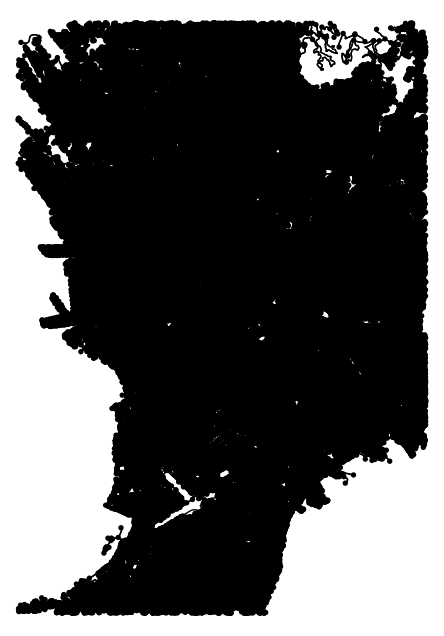

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [26]:
ox.plot_graph(metro_manila_graph, bgcolor='#ffffff', node_color='#000000', edge_color='#000000')

In [5]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(metro_manila_graph)

In [6]:
gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
12067302,14.541506,120.994972,3,NaN,NaN,POINT (120.99497 14.54151)
12067308,14.537867,120.995733,3,NaN,NaN,POINT (120.99573 14.53787)
12067317,14.540634,120.992152,3,NaN,NaN,POINT (120.99215 14.54063)
12067327,14.556251,120.988315,3,NaN,NaN,POINT (120.98831 14.55625)
12067330,14.559643,120.987132,4,traffic_signals,NaN,POINT (120.98713 14.55964)


In [7]:
gdf_edges.head()

osmid                   name  \
u        v          key                                                  
12067302 1686647100 0                   2667105     E. Manaloto Street   
         2950125788 0                 224039651  F. B. Harrison Street   
         6510185271 0                 224039651  F. B. Harrison Street   
12067308 8562405196 0                 224039655  F. B. Harrison Street   
         1723298722 0    [644875507, 840378998]                   EDSA   

                             highway  oneway reversed   length   lanes  \
u        v          key                                                  
12067302 1686647100 0    residential   False     True  129.271     NaN   
         2950125788 0      secondary   False    False   34.788       2   
         6510185271 0      secondary   False     True   64.711       2   
12067308 8562405196 0      secondary   False     True    6.003       2   
         1723298722 0          trunk    True    False  175.734  [4, 5]   

                        maxspeed width  \
u        v          key                  
12067302 1686647100 0        NaN   NaN   
         2950125788 0         40     8   
         6510185271 0         40     8   
12067308 8562405196 0         40     8   
         1723298722 0         60   NaN   

                                                                  geometry  \
u        v          key                                                      
12067302 1686647100 0    LINESTRING (120.99497 14.54151, 120.99380 14.5...   
         2950125788 0    LINESTRING (120.99497 14.54151, 120.99504 14.5...   
         6510185271 0    LINESTRING (120.99497 14.54151, 120.99486 14.5...   
12067308 8562405196 0    LINESTRING (120.99573 14.53787, 120.99572 14.5...   
         1723298722 0    LINESTRING (120.99573 14.53787, 120.99516 14.5...   

                         ref access junction tunnel bridge service  
u        v          key                                             
12067302 1686647100 0    NaN    NaN      NaN    NaN    NaN     NaN  
         2950125788 0    NaN    NaN      NaN    NaN    NaN     NaN  
         6510185271 0    NaN    NaN      NaN    NaN    NaN     NaN  
12067308 8562405196 0    NaN    NaN      NaN    NaN    NaN     NaN  
         1723298722 0      1    NaN      NaN    NaN    NaN     NaN

In [59]:
pandas_graph = nx.to_pandas_edgelist(metro_manila_graph)

In [65]:
edge_map = mg.wrappers.EdgeMap.PandasEdgeMap(pandas_graph, 'source', 'target', 'length', is_directed=True)
edge_map.value

,source,target,lanes,length,access,width,highway,name,ref,reversed,service,bridge,junction,geometry,tunnel,maxspeed,oneway,osmid
0,12067302,2950125788,2,34.788,NaN,8,secondary,F. B. Harrison Street,NaN,False,NaN,NaN,NaN,"LINESTRING (120.9949722 14.5415061, 120.995042...",NaN,40,False,224039651
1,12067308,8562405196,2,6.003,NaN,8,secondary,F. B. Harrison Street,NaN,True,NaN,NaN,NaN,NaN,NaN,40,False,224039655
2,12067308,1723298722,"[4, 5]",175.734,NaN,NaN,trunk,EDSA,1,False,NaN,NaN,NaN,"LINESTRING (120.9957327 14.5378672, 120.995158...",NaN,60,True,"[644875507, 840378998]"
3,12067317,21590567,1,20.808,NaN,NaN,service,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,False,4075803
4,12067317,25389240,4,13.166,NaN,NaN,trunk,Roxas Boulevard,120,False,NaN,NaN,NaN,NaN,NaN,60,True,909949886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344290,12285148891,12285148889,NaN,3.266,NaN,NaN,footway,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,False,1327842578
344291,12285148893,12285148894,NaN,4.771,NaN,NaN,footway,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,False,1327755851
344292,12285148893,1034880976,NaN,50.020,NaN,NaN,"[steps, footway]",NaN,NaN,False,NaN,yes,NaN,"LINESTRING (120.9771193 14.5951867, 120.977276...",NaN,NaN,False,"[1327755850, 89184406, 1077730799]"
344293,12285148893,12284519901,NaN,52.417,NaN,NaN,footway,NaN,NaN,"[False, True]",NaN,NaN,NaN,"LINESTRING (120.9771193 14.5951867, 120.977081...",NaN,NaN,False,"[1327755851, 1327755855]"


In [66]:
metro_manila_metagraph = mg.algos.util.graph.build(edge_map)
metro_manila_metagraph

In [10]:
gdf_edges.columns

Index(['osmid', 'name', 'highway', 'oneway', 'reversed', 'length', 'lanes',
       'maxspeed', 'width', 'geometry', 'ref', 'access', 'junction', 'tunnel',
       'bridge', 'service'],
      dtype='object')

In [11]:
gdf_nodes.columns

Index(['y', 'x', 'street_count', 'highway', 'ref', 'geometry'], dtype='object')

In [16]:
path = graph_search_algorithm_compilation.bidirectional_search(metro_manila_graph, 12067302, 12067308)
path

[12067302,
 2950125788,
 5354424837,
 24785165,
 5651175582,
 25388521,
 8317435077,
 25389123,
 25388522,
 978165773,
 445413656,
 8562405196,
 12067308]

#### Monte Carlo with Graph of Metro Manila

In [ ]:
iterations = 2
flooded_road_probability = 0.1
metro_manila_graph_flooded = apply_flood_conditions(metro_manila_graph, flooded_road_probability)
algorithm_performance = monte_carlo_simulation(metro_manila_graph, iterations)

  0%|          | 0/2 [6:22:16<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Choose the best algorithm based on performance
best_algorithm, best_path = choose_best_algorithm(algorithm_performance)

# Display the best algorithm's path
print(f"Best path found by {best_algorithm}: {best_path}")

# Plot the average performance
average_performance = {
    algo: sum(duration for duration, _ in times) / len(times)
    for algo, times in algorithm_performance.items()
}
plt.bar(average_performance.keys(), average_performance.values())
plt.title(f"Average Algorithm Performance (Lower is Better), Iterations: {iterations}")
plt.yscale('log')
plt.xlabel("Algorithm")
plt.ylabel("Average Time (s) / Infinite Cost (logarithmic scale)")
plt.xticks(rotation=45)
plt.show()

### Conclusion